# Deep Learning for Automatic Pneumonia Detection

This notebook builds and trains a convolutional neural network (CNN) from scratch to classify and detect the presence of pneumonia from a collection of chest X-ray image samples. The point of constructing the network from scratch is to extract features from a given chest X-ray image and classify it to determine a person as either having pneumonia or not having pneumonia.

What makes this model distinctive is that it was trained from scratch, which separates it from other methods that rely heavily on transfer learning approach.

The dataset can be downloaded from the kaggle website which can be found [here](kaggle.com/paultimothymooney/chest-xray-pneumonia).

In [1]:
# import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.preprocessing import image
from mlxtend.plotting import plot_confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.layers import Dense, Conv2D, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# define some variables for later usage
epochs = 10
img_size = 150
batch_size = 32
drct_path = '/Downloads/chest_xray/'

Display some images from both types to have a look at how much different they look by the naked eye

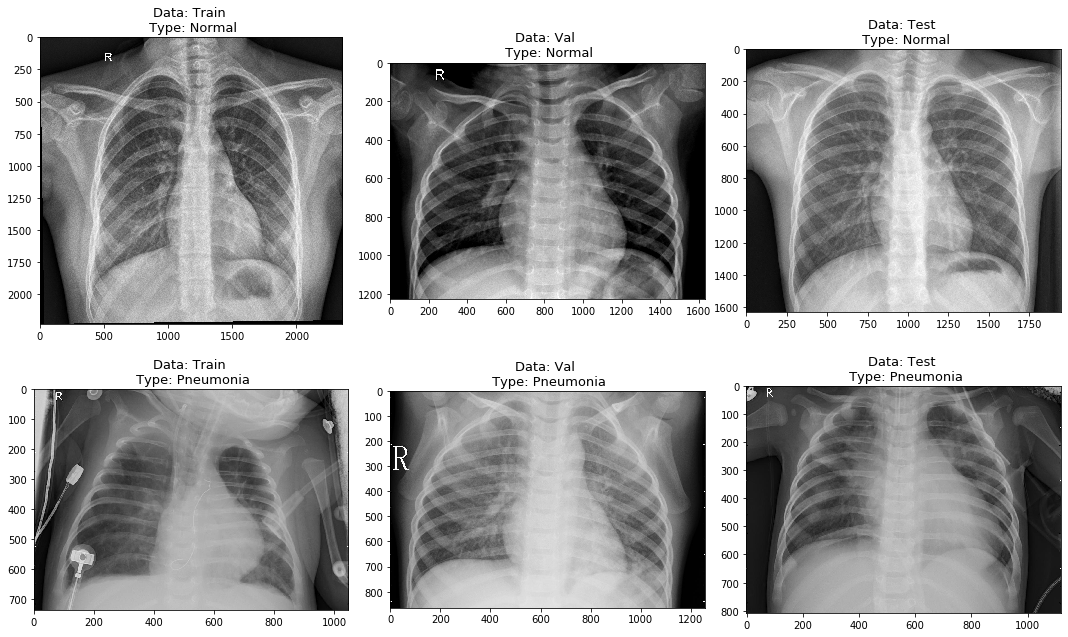

In [4]:
fig, ax = plt.subplots(2, 3, figsize = (15, 9))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['Train', 'Val', 'Test']):
    set_path = drct_path + _set
    ax[i].imshow(plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0]), cmap = 'gray')
    ax[i].set_title('Data: {} \n Type: Normal'.format(_set), fontsize = 13)
    ax[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0]), cmap = 'gray')
    ax[i+3].set_title('Data: {} \n Type: Pneumonia'.format(_set), fontsize = 13)

In [5]:
# check the shape of some images from both types
img_n = plt.imread(set_path + '/NORMAL/' + os.listdir(set_path + '/NORMAL')[0])
img_p = plt.imread(set_path + '/PNEUMONIA/' + os.listdir(set_path + '/PNEUMONIA')[0])
print(f'Normal size:  {img_n.shape}')
print(f'Pneumonia size:  {img_p.shape}')

Normal size:  (1632, 1949)
Pneumonia size:  (808, 1120)


In [6]:
# check the no. of validating images for each type
print ('Normal counts: {}'.format(len(os.listdir(drct_path + 'val/NORMAL/'))))
print ('Pneumonia counts: {}'.format(len(os.listdir(drct_path + 'val/PNEUMONIA/'))))

Normal counts: 8
Pneumonia counts: 8


In [7]:
# check the no. of test images for each type
print ('Normal counts: {}'.format(len(os.listdir(drct_path + 'test/NORMAL/'))))
print ('Pneumonia counts: {}'.format(len(os.listdir(drct_path + 'test/PNEUMONIA/'))))

Normal counts: 234
Pneumonia counts: 390


In [8]:
# check the no. of training images for each type
print ('Normal counts: {}'.format(len(os.listdir(drct_path + 'train/NORMAL/'))))
print ('Pneumonia counts: {}'.format(len(os.listdir(drct_path + 'train/PNEUMONIA/'))))

Normal counts: 1341
Pneumonia counts: 3875


The above script shows how the dataset is highly imbalanced as the number of pneumonia classes by far exceeds the number of normal classes. However this is very normal situation  when it comes to medical data. Now we need to tackle this imbalanced issue

We can handle this imbalanced issue by applying data augmentation technique to enlarge the size of the minority class (Normal images) in order to optimise the performance of the model and avoid overfitting. Moreover, data augmentation doesn't affect the distribution of labels in the original dataset
and improve variance

For the data augmentation, we gonna to:

1. Rescale pixel values from the range of 0-255 to the range 0-1
2. Randomly Zoom by 30% some training images
3. Randomly flip images vertically

In [9]:
# ImageDataGenerator allow the network to "see" more diversified,
# but still representative, data points during training

train_datagen = ImageDataGenerator(rescale = 1./255, # transform pixeles from range 0-255 to range 0-1
                                   zoom_range = 0.3, # randomly zoom image 
                                   vertical_flip = True) # randomly flip images


# load a mini batch of images directly from the source folder then convert them into a vector of attributes
training_set = train_datagen.flow_from_directory(directory = drct_path + 'train',
                                                 batch_size = batch_size,
                                                 target_size = (img_size, img_size),
                                                 shuffle = True,
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [10]:
# prepare test data
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(directory = drct_path + 'test',
                                            batch_size = batch_size,
                                            target_size = (img_size, img_size),
                                            shuffle = True,
                                            class_mode = 'binary')

Found 624 images belonging to 2 classes.


In [11]:
# prepare validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

validation_set = val_datagen.flow_from_directory(directory = drct_path + 'val',
                                                    batch_size = batch_size,
                                                    target_size = (img_size, img_size),
                                                    shuffle = True,
                                                    class_mode = 'binary')

Found 16 images belonging to 2 classes.


# Build the Model

We gonna build a CNN that has 5 Convolution layers. After each convolution, we will add a Pooling layer using max-pooling. After the final convolutional layer, we will add some Fully Connected layers after the flattening step, these nodes will act as an input layer to these fully-connected layers. Dense is the function to add a fully connected layer, "units" is where we define the number of nodes that should be present in this hidden layer. The scond Fully Connected layer or the output layer has only 1 "unit" becuase it needs to predict the respective output (if someone has pneumonia)

In [12]:
model = Sequential()

# 1st conv
model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = (img_size, img_size, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))

# 2nd conv
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd conv
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# 4th conv
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

# 5th conv
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

# fully connected layer
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))

# output layer
model.add(Dense(units = 1, activation = 'sigmoid'))

In [13]:
# show the complete summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

# Compile and Train the Model

In [14]:
# compile the sequential model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
# callbacks
checkpoint = ModelCheckpoint(filepath = 'best_weights.hdf5', save_best_only = True, save_weights_only = True)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, verbose = 2, mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 1, mode = 'min')

In [21]:
test_set.samples // batch_size

19

In [22]:
# fit the data to the cnn model
cnn = model.fit_generator(training_set,
                          epochs = epochs,
                          steps_per_epoch = training_set.samples // batch_size,
                          validation_data = validation_set,
                          validation_steps = test_set.samples // batch_size,
                          callbacks = [checkpoint, lr_reduce])                           

Epoch 1/10
163/163 [==============================] - 321s 2s/step - loss: 0.2162 - accuracy: 0.9151 - val_loss: 0.4932 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 273s 2s/step - loss: 0.1969 - accuracy: 0.9231 - val_loss: 3.5557 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 278s 2s/step - loss: 0.1860 - accuracy: 0.9302 - val_loss: 1.1792 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 302s 2s/step - loss: 0.1834 - accuracy: 0.9310 - val_loss: 0.5490 - val_accuracy: 0.6875

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
163/163 [==============================] - 297s 2s/step - loss: 0.1466 - accuracy: 0.9500 - val_loss: 1.1374 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 337s 2s/step - loss: 0.1362 - accuracy: 0.9511 - val_loss: 1.3210 - val_accuracy: 0.5000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.0

Now that we have trained our model lets see how it did on the data:

Predicted : Pnuemonia
Actual : Pnuemonia


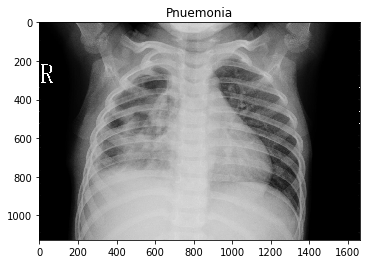

In [23]:
rand_img = np.random.randint(0, len(os.listdir(drct_path + 'val/PNEUMONIA/')))
rand_img_path = drct_path + 'val/PNEUMONIA/' + os.listdir(drct_path + 'val/PNEUMONIA/')[rand_img]

img = plt.imread(rand_img_path)
img = cv2.resize(img, (img_size, img_size))
img = np.dstack([img, img, img])
img = img.astype('float32') / 255
result = model.predict(np.expand_dims(image.img_to_array(img), axis = 0))  

if result[0][0] > 0.5:
  prediction = 'Pnuemonia'
else:
  prediction = 'Normal'
  
print(f'Predicted : ' + prediction)
print ('Actual : Pnuemonia')

image = plt.imread(rand_img_path)
plt.imshow(image)
plt.title('Pnuemonia')
plt.imshow(image, cmap = 'gray')


# Model Evaluation

Let's visualise the loss and accuracy plots

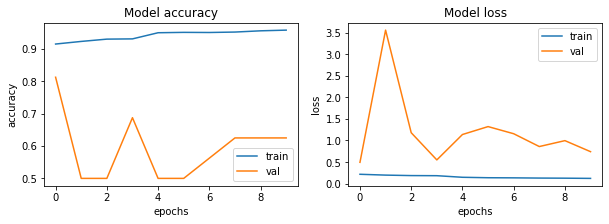

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(cnn.history[met])
    ax[i].plot(cnn.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
test_data = []
test_labels = []

for title in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(drct_path + 'test' + title)):
            img = plt.imread(drct_path + 'test' + title + img)
            img = cv2.resize(img, (img_size, img_size))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if title == '/NORMAL/':
                label = 0
            elif title == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)
# get predictions
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
# get the confusion matrix
mat = confusion_matrix(test_labels, np.round(preds))

Let’s plot the confusion matrix and get some other metrics like precision, recall, F1 score and accuracy

Text(0.5, 1.0, 'Confusion Matrix')

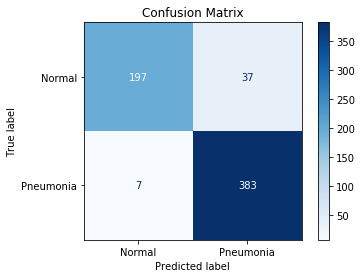

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(mat, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

In [27]:
# calculate precision and recall
tn, fp, fn, tp = mat.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

Test Metrics:
Accuracy: 92.94871794871796%
Precision: 91.19047619047619%
Recall: 98.2051282051282%
F1-score: 94.56790123456791


The model is able to achieve an accuracy of 93% which is quite good considering the size of data that is used. Yet, the main reason behind this low accuracy is that we don't have enough observations as it's difficult to obtain a large amount of pneumonia dataset for this classification task, unlike other deep learning classification tasks that have sufficient image repository.

In [28]:
print('Train Metric:')
print('Train accuracy: {}%'.format(np.round(cnn.history['accuracy'][-1]*100, 2)))

Train Metric:
Train accuracy: 95.8%
